In [1]:
import ast
import swifter

def filter_topic_distribution(topic_distribution_list):
    theta = 0.1
    t1_list = []
    distribution_list = ast.literal_eval(topic_distribution_list)
    for distribution in distribution_list:
        filtered_distribution = [{k: v} for k, v in distribution.items() if v > theta]
        t1_list.extend(filtered_distribution)
    return t1_list

In [2]:
def get_dominant_topics(sentence_topic_distribution):
    dominant_topics = []
    for distribution in sentence_topic_distribution:
        dominant_topic = max(distribution, key=distribution.get)
        dominant_topics.append(dominant_topic)
    return dominant_topics

In [3]:
def get_topic_words(row):
    index_values = row['ST']
    topic_words = row['topic_words']
    result = []
    for index in index_values:
        if 0 <= index < len(topic_words):
            result.append(topic_words[index])
        else:
            result.append(None) 
    return result

In [4]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from senticnet.senticnet import SenticNet
sid = SentimentIntensityAnalyzer()
sn = SenticNet()


def sentic(word):
     score=0
     if word in sn.data:
        sentiment_info = sn.concept(word)
        score = float(sentiment_info.get('polarity_value', 0))
     return score

def TEXTBLOB(word):  
    sentiment_score=TextBlob(word).sentiment.polarity
    return sentiment_score

def SA(word):
     sentiment_score = sid.polarity_scores(word)['compound'] 
     return sentiment_score
  
def match_and_calculate_sentiment(sentences, topic_words):
    sentiment_scores = []
    
    for sentence, words in zip(sentences, topic_words):
        sentiment_score=0
        for word in nltk.word_tokenize(sentence):
            if word in words:
                sentiment_score += (TEXTBLOB(word))
        sentiment_scores.append(sentiment_score)
        
    return sentiment_scores

In [5]:
def calculate_reaching_definition(df,r):
    definitions_generated = []
    definitions_killed = []
    
    for index, row in df.iterrows():
        row_definitions_generated = [set() for _ in range(len(row['processed']))]
        row_definitions_killed = [set() for _ in range(len(row['processed']))]
        
        for i, (sentence, topic_idx, sentiment_score) in enumerate(zip(row['processed'], row['ST'], row[r])):
            definition_generated = (topic_idx, sentiment_score)
            for j in range(i):
                if (row['ST'][j], row[r][j]) == definition_generated:
                    row_definitions_killed[i].add(j)
            row_definitions_generated[i].add(definition_generated)
            for j in range(i):
                if j not in row_definitions_killed[i]:
                    row_definitions_generated[i] |= row_definitions_generated[j]
        
        definitions_generated.append(row_definitions_generated)
        definitions_killed.append(row_definitions_killed)
    
    df['definitions_generated'] = definitions_generated
    df['definitions_killed'] = definitions_killed
    
    return df

In [6]:
def calculate_IN_OUT_sets(definitions_generated_col, definitions_killed_col):
    IN_sets = []
    OUT_sets = []
    for gen, killed in zip(definitions_generated_col, definitions_killed_col):
        OUT = [set() for _ in range(len(gen))]
        changed = True
        while changed:
            changed = False
            for i in range(len(gen)):
                IN = set().union(*[OUT[p] for p in range(len(gen)) if i not in killed[p]])
                new_OUT = gen[i].union(IN - killed[i])
                if new_OUT != OUT[i]:
                    OUT[i] = new_OUT
                    changed = True
        IN = [set().union(*[OUT[p] for p in range(len(gen)) if i in gen[p]]) for i in range(len(gen))]
        IN_sets.append(IN)
        OUT_sets.append(OUT)
    return IN_sets, OUT_sets

In [7]:
def generate_summary(sentences, S, sentiment_scores):
    summaries = []

    for doc_sentences, out, doc_sentiment_scores in zip(sentences, S, sentiment_scores):
        summary = ""
        added_indices = set()

        for out_set in out:
            for j in out_set:
                if isinstance(j, tuple):
                    j = j[0]
                j = int(j)  
                if 0 <= j < len(doc_sentences) and j < len(doc_sentiment_scores):
                    if j not in added_indices:
                        summary += doc_sentences[j] + " "
                        added_indices.add(j)

        summaries.append(summary.strip())

    return summaries

In [8]:
from bs4 import BeautifulSoup
import contractions
import re
def preprocess_text(text):
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    text = contractions.fix(text)
    text = re.sub(r'\\', '', text)
    return text

In [9]:
def classify_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        return 'postive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'


In [10]:
import pandas as pd

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

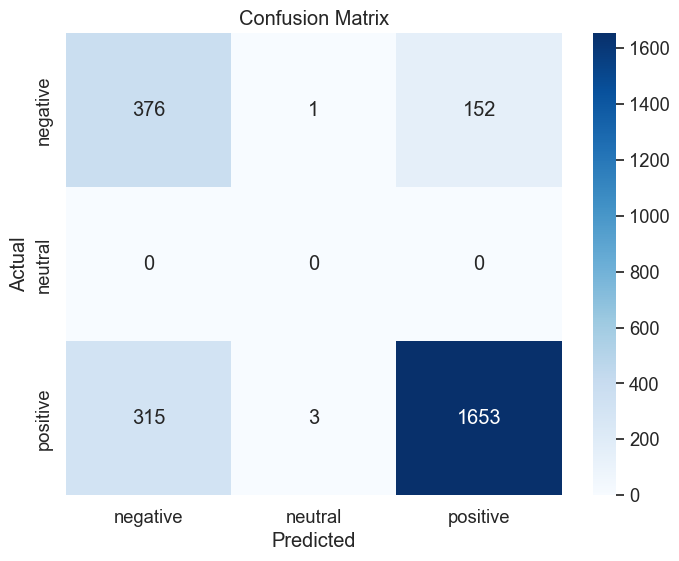

Accuracy: 0.8116
Precision: 0.8371482184477113
Recall: 0.8116
F1-score: 0.820696437204779


C:\Users\akvnr\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Iter = pd.read_csv('GA-1.csv')
Iter['DTC'] = Iter['sentence_topic_distributions'].swifter.apply(filter_topic_distribution)
Iter['ST']=Iter['DTC'].swifter.apply(get_dominant_topics)
Iter['topic_word'] = Iter['topic_words'].swifter.apply(ast.literal_eval)
Iter['ATW'] = Iter.swifter.apply(get_topic_words, axis=1)
Iter['processed'] = Iter['processed'].swifter.apply(ast.literal_eval)
Iter['sentiment_score'] = Iter.swifter.apply(lambda row: match_and_calculate_sentiment(row['processed'], row['ATW']), axis=1)
df=calculate_reaching_definition(Iter,'sentiment_score')
IN_sets, OUT_sets = calculate_IN_OUT_sets(df['definitions_generated'], df['definitions_killed'])

S = [0] * len(OUT_sets)
for i, out_set in enumerate(OUT_sets):
    S[i] = list(out_set)[-1] if out_set else None


Iter['sentence'] = Iter['sentence'].swifter.apply(ast.literal_eval)
summaries = generate_summary(Iter['sentence'], S, Iter['sentiment_score'])
summary1 = pd.DataFrame({'Summary': summaries})

Iter['TBLabel']=Iter['Reviews'].swifter.apply( classify_sentiment)
summary1['TBLabel']=summary1['Summary'].swifter.apply( classify_sentiment)


actual = Iter['TBLabel']
predicted = summary1['TBLabel']

cm = confusion_matrix(actual, predicted)
labels =['negative','neutral','positive']

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy1 = accuracy_score(actual, predicted)
precision1 = precision_score(actual, predicted, average='weighted')
recall1 = recall_score(actual, predicted, average='weighted')
f11 = f1_score(actual, predicted, average='weighted')
print("Accuracy:", accuracy1)
print("Precision:", precision1)
print("Recall:", recall1)
print("F1-score:", f11)

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

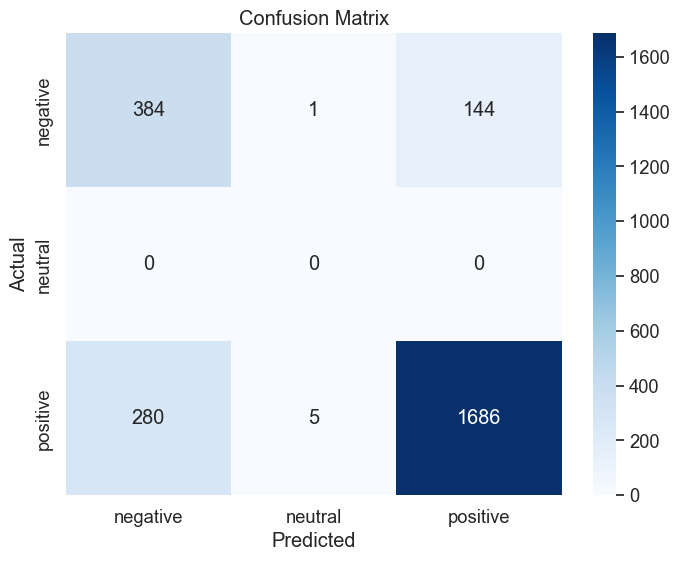

Accuracy: 0.828
Precision: 0.848733051550464
Recall: 0.828
F1-score: 0.8356358145482958


C:\Users\akvnr\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
Iter = pd.read_csv('GA-2.csv')
Iter['DTC'] = Iter['sentence_topic_distributions'].swifter.apply(filter_topic_distribution)
Iter['ST']=Iter['DTC'].swifter.apply(get_dominant_topics)
Iter['topic_word'] = Iter['topic_words'].swifter.apply(ast.literal_eval)
Iter['ATW'] = Iter.swifter.apply(get_topic_words, axis=1)
Iter['processed'] = Iter['processed'].swifter.apply(ast.literal_eval)
Iter['sentiment_score'] = Iter.swifter.apply(lambda row: match_and_calculate_sentiment(row['processed'], row['ATW']), axis=1)
df=calculate_reaching_definition(Iter,'sentiment_score')
IN_sets, OUT_sets = calculate_IN_OUT_sets(df['definitions_generated'], df['definitions_killed'])

S = [0] * len(OUT_sets)
for i, out_set in enumerate(OUT_sets):
    S[i] = list(out_set)[-1] if out_set else None


Iter['sentence'] = Iter['sentence'].swifter.apply(ast.literal_eval)
summaries = generate_summary(Iter['sentence'], S, Iter['sentiment_score'])
summary2 = pd.DataFrame({'Summary': summaries})

Iter['TBLabel']=Iter['Reviews'].swifter.apply( classify_sentiment)
summary2['TBLabel']=summary2['Summary'].swifter.apply( classify_sentiment)


actual = Iter['TBLabel']
predicted = summary2['TBLabel']

cm = confusion_matrix(actual, predicted)
labels =['negative','neutral','positive']

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy2 = accuracy_score(actual, predicted)
precision2 = precision_score(actual, predicted, average='weighted')
recall2 = recall_score(actual, predicted, average='weighted')
f12 = f1_score(actual, predicted, average='weighted')
print("Accuracy:", accuracy2)
print("Precision:", precision2)
print("Recall:", recall2)
print("F1-score:", f12)

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

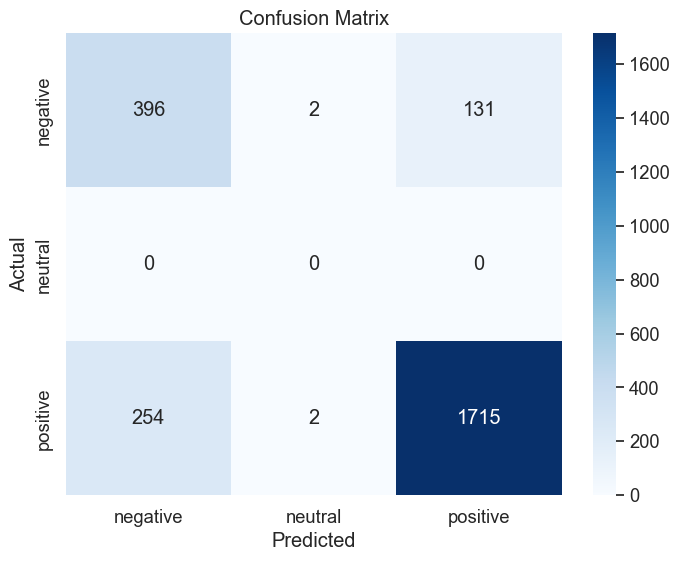

Accuracy: 0.8444
Precision: 0.8613650184182016
Recall: 0.8444
F1-score: 0.8506087983248904


C:\Users\akvnr\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
Iter = pd.read_csv('GA-3.csv')
Iter['DTC'] = Iter['sentence_topic_distributions'].swifter.apply(filter_topic_distribution)
Iter['ST']=Iter['DTC'].swifter.apply(get_dominant_topics)
Iter['topic_word'] = Iter['topic_words'].swifter.apply(ast.literal_eval)
Iter['ATW'] = Iter.swifter.apply(get_topic_words, axis=1)
Iter['processed'] = Iter['processed'].swifter.apply(ast.literal_eval)
Iter['sentiment_score'] = Iter.swifter.apply(lambda row: match_and_calculate_sentiment(row['processed'], row['ATW']), axis=1)
df=calculate_reaching_definition(Iter,'sentiment_score')
IN_sets, OUT_sets = calculate_IN_OUT_sets(df['definitions_generated'], df['definitions_killed'])

S = [0] * len(OUT_sets)
for i, out_set in enumerate(OUT_sets):
    S[i] = list(out_set)[-1] if out_set else None


Iter['sentence'] = Iter['sentence'].swifter.apply(ast.literal_eval)
summaries = generate_summary(Iter['sentence'], S, Iter['sentiment_score'])
summary3 = pd.DataFrame({'Summary': summaries})

Iter['TBLabel']=Iter['Reviews'].swifter.apply( classify_sentiment)
summary3['TBLabel']=summary3['Summary'].swifter.apply( classify_sentiment)


actual = Iter['TBLabel']
predicted = summary3['TBLabel']

cm = confusion_matrix(actual, predicted)
labels =['negative','neutral','positive']

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy3 = accuracy_score(actual, predicted)
precision3 = precision_score(actual, predicted, average='weighted')
recall3 = recall_score(actual, predicted, average='weighted')
f13 = f1_score(actual, predicted, average='weighted')
print("Accuracy:", accuracy3)
print("Precision:", precision3)
print("Recall:", recall3)
print("F1-score:", f13)

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

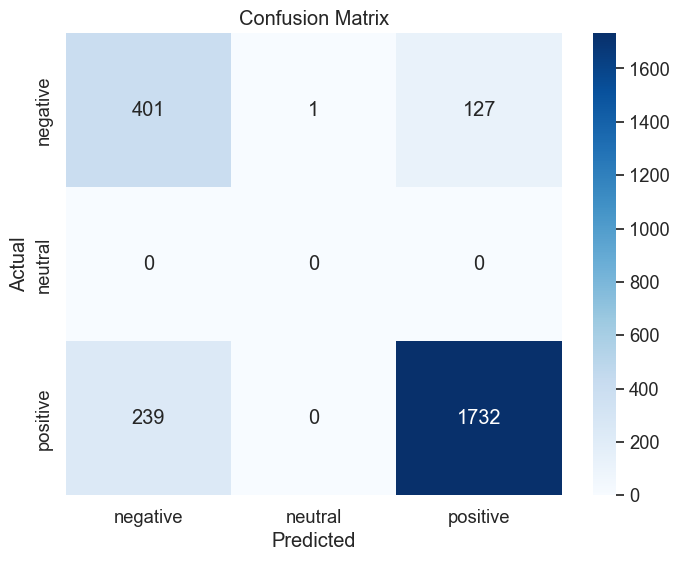

Accuracy: 0.8532
Precision: 0.8671200548009683
Recall: 0.8532
F1-score: 0.8582289722085108


C:\Users\akvnr\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
Iter = pd.read_csv('GA-4.csv')
Iter['DTC'] = Iter['sentence_topic_distributions'].swifter.apply(filter_topic_distribution)
Iter['ST']=Iter['DTC'].swifter.apply(get_dominant_topics)
Iter['topic_word'] = Iter['topic_words'].swifter.apply(ast.literal_eval)
Iter['ATW'] = Iter.swifter.apply(get_topic_words, axis=1)
Iter['processed'] = Iter['processed'].swifter.apply(ast.literal_eval)
Iter['sentiment_score'] = Iter.swifter.apply(lambda row: match_and_calculate_sentiment(row['processed'], row['ATW']), axis=1)
df=calculate_reaching_definition(Iter,'sentiment_score')
IN_sets, OUT_sets = calculate_IN_OUT_sets(df['definitions_generated'], df['definitions_killed'])

S = [0] * len(OUT_sets)
for i, out_set in enumerate(OUT_sets):
    S[i] = list(out_set)[-1] if out_set else None


Iter['sentence'] = Iter['sentence'].swifter.apply(ast.literal_eval)
summaries = generate_summary(Iter['sentence'], S, Iter['sentiment_score'])
summary4 = pd.DataFrame({'Summary': summaries})

Iter['TBLabel']=Iter['Reviews'].swifter.apply( classify_sentiment)
summary4['TBLabel']=summary4['Summary'].swifter.apply( classify_sentiment)


actual = Iter['TBLabel']
predicted = summary4['TBLabel']

cm = confusion_matrix(actual, predicted)
labels =['negative','neutral','positive']

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy4 = accuracy_score(actual, predicted)
precision4 = precision_score(actual, predicted, average='weighted')
recall4 = recall_score(actual, predicted, average='weighted')
f14 = f1_score(actual, predicted, average='weighted')
print("Accuracy:", accuracy4)
print("Precision:", precision4)
print("Recall:", recall4)
print("F1-score:", f14)

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

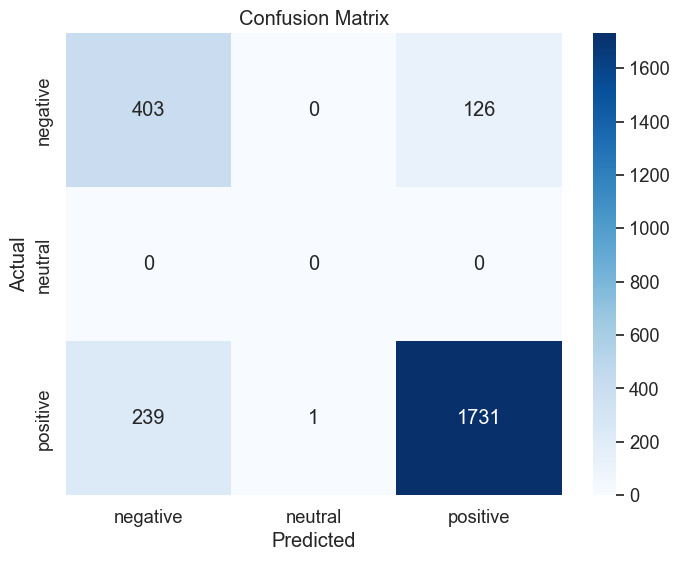

Accuracy: 0.8536
Precision: 0.8677327686601342
Recall: 0.8536
F1-score: 0.8586644691861042


C:\Users\akvnr\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
Iter = pd.read_csv('GA-5.csv')
Iter['DTC'] = Iter['sentence_topic_distributions'].swifter.apply(filter_topic_distribution)
Iter['ST']=Iter['DTC'].swifter.apply(get_dominant_topics)
Iter['topic_word'] = Iter['topic_words'].swifter.apply(ast.literal_eval)
Iter['ATW'] = Iter.swifter.apply(get_topic_words, axis=1)
Iter['processed'] = Iter['processed'].swifter.apply(ast.literal_eval)
Iter['sentiment_score'] = Iter.swifter.apply(lambda row: match_and_calculate_sentiment(row['processed'], row['ATW']), axis=1)
df=calculate_reaching_definition(Iter,'sentiment_score')
IN_sets, OUT_sets = calculate_IN_OUT_sets(df['definitions_generated'], df['definitions_killed'])

S = [0] * len(OUT_sets)
for i, out_set in enumerate(OUT_sets):
    S[i] = list(out_set)[-1] if out_set else None


Iter['sentence'] = Iter['sentence'].swifter.apply(ast.literal_eval)
summaries = generate_summary(Iter['sentence'], S, Iter['sentiment_score'])
summary5 = pd.DataFrame({'Summary': summaries})

Iter['TBLabel']=Iter['Reviews'].swifter.apply( classify_sentiment)
summary5['TBLabel']=summary5['Summary'].swifter.apply( classify_sentiment)


actual = Iter['TBLabel']
predicted = summary5['TBLabel']

cm = confusion_matrix(actual, predicted)
labels =['negative','neutral','positive']

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy5 = accuracy_score(actual, predicted)
precision5 = precision_score(actual, predicted, average='weighted')
recall5 = recall_score(actual, predicted, average='weighted')
f15 = f1_score(actual, predicted, average='weighted')
print("Accuracy:", accuracy5)
print("Precision:", precision5)
print("Recall:", recall5)
print("F1-score:", f15)

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

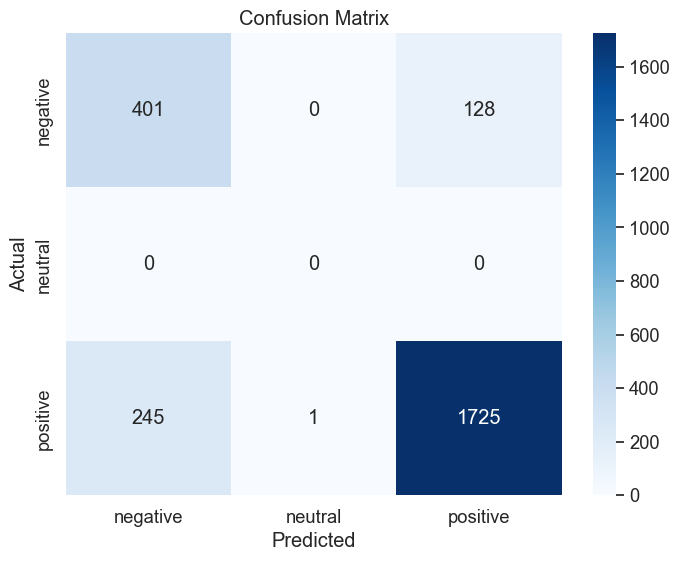

Accuracy: 0.8504
Precision: 0.8652887834805578
Recall: 0.8504
F1-score: 0.855720096323333


C:\Users\akvnr\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
Iter = pd.read_csv('GA-6.csv')
Iter['DTC'] = Iter['sentence_topic_distributions'].swifter.apply(filter_topic_distribution)
Iter['ST']=Iter['DTC'].swifter.apply(get_dominant_topics)
Iter['topic_word'] = Iter['topic_words'].swifter.apply(ast.literal_eval)
Iter['ATW'] = Iter.swifter.apply(get_topic_words, axis=1)
Iter['processed'] = Iter['processed'].swifter.apply(ast.literal_eval)
Iter['sentiment_score'] = Iter.swifter.apply(lambda row: match_and_calculate_sentiment(row['processed'], row['ATW']), axis=1)
df=calculate_reaching_definition(Iter,'sentiment_score')
IN_sets, OUT_sets = calculate_IN_OUT_sets(df['definitions_generated'], df['definitions_killed'])

S = [0] * len(OUT_sets)
for i, out_set in enumerate(OUT_sets):
    S[i] = list(out_set)[-1] if out_set else None


Iter['sentence'] = Iter['sentence'].swifter.apply(ast.literal_eval)
summaries = generate_summary(Iter['sentence'], S, Iter['sentiment_score'])
summary6 = pd.DataFrame({'Summary': summaries})

Iter['TBLabel']=Iter['Reviews'].swifter.apply( classify_sentiment)
summary6['TBLabel']=summary6['Summary'].swifter.apply( classify_sentiment)


actual = Iter['TBLabel']
predicted = summary6['TBLabel']

cm = confusion_matrix(actual, predicted)
labels =['negative','neutral','positive']

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy6 = accuracy_score(actual, predicted)
precision6 = precision_score(actual, predicted, average='weighted')
recall6 = recall_score(actual, predicted, average='weighted')
f16 = f1_score(actual, predicted, average='weighted')
print("Accuracy:", accuracy6)
print("Precision:", precision6)
print("Recall:", recall6)
print("F1-score:", f16)

In [17]:
acc =[accuracy1,accuracy2,accuracy3,accuracy4,accuracy5,accuracy6]
pre =[precision1,precision2,precision3,precision4,precision5,precision6]
rec =[recall1,recall2,recall3,recall4,recall5,recall6]
f1s =[f11,f12,f13,f14,f15,f16]

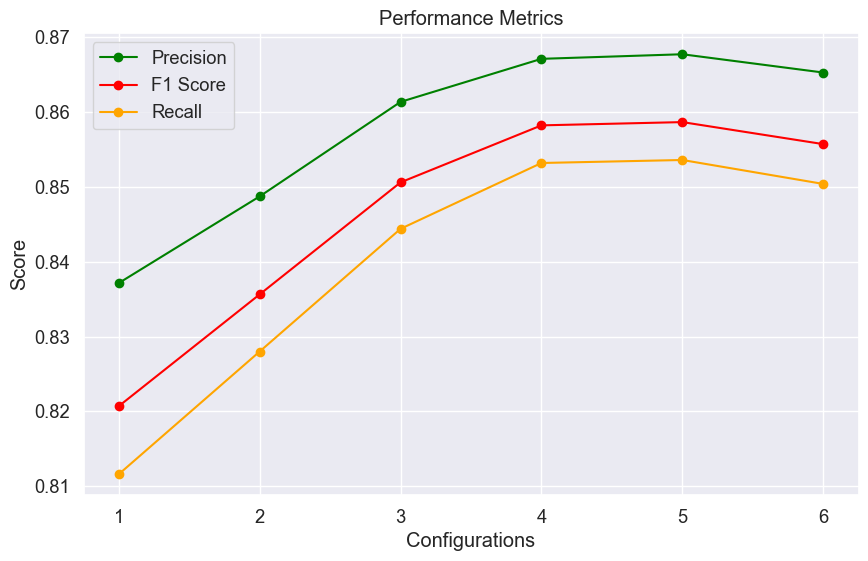

In [18]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10, 6))
settings=[1,2,3,4,5,6]
plt.plot(settings, pre, marker='o', label='Precision', color='green')
plt.plot(settings, f1s, marker='o', label='F1 Score', color='red')
plt.plot(settings, rec, marker='o', label='Recall', color='orange')
plt.xlabel('Configurations')
plt.ylabel('Score')
plt.title('Performance Metrics')
plt.legend()
plt.grid(True)
plt.show()


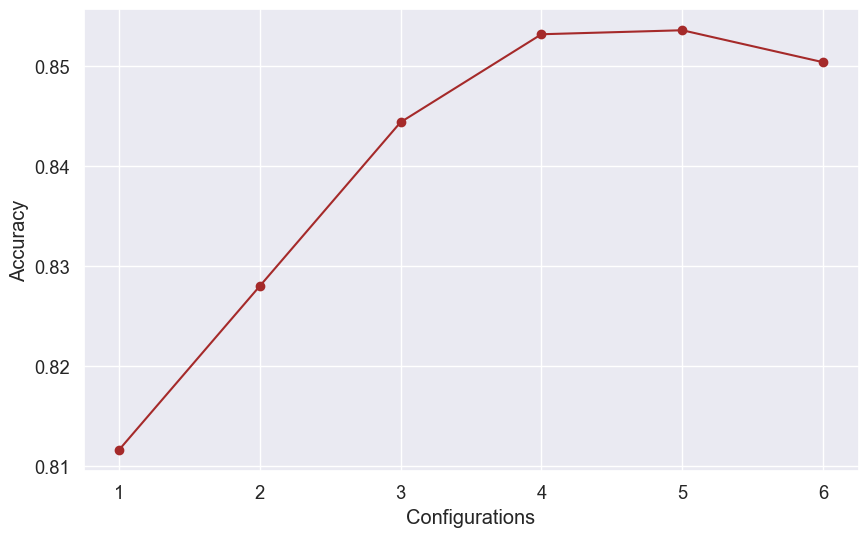

In [19]:
import matplotlib.pyplot as plt1

plt1.figure(figsize=(10, 6))
plt1.plot(settings, acc, marker='o', label='Accuracy', color='brown')
plt1.xlabel('Configurations')
plt1.ylabel('Accuracy')
plt1.grid(True)
plt1.show()

In [20]:
ch1=pd.read_csv('GA-1.csv')
ch2=pd.read_csv('GA-2.csv')
ch3=pd.read_csv('GA-3.csv')
ch4=pd.read_csv('GA-4.csv')
ch5=pd.read_csv('GA-5.csv')
ch6=pd.read_csv('GA-6.csv')

In [21]:
def avg(df, column_name):
    column = df[column_name]
    if len(column) == 0:
        return 0  
    total_score = sum(column)
    avg_score = total_score / len(column)
    return avg_score

In [22]:
coherence=[avg(ch1,'coherence_score'),avg(ch2,'coherence_score'),avg(ch3,'coherence_score'),avg(ch4,'coherence_score'),avg(ch5,'coherence_score'),avg(ch6,'coherence_score')]

In [23]:
coherence

[0.4565771718638657,
 0.4616467160066736,
 0.47077513602149057,
 0.48873900321148694,
 0.5063198620275412,
 0.5138386913442525]

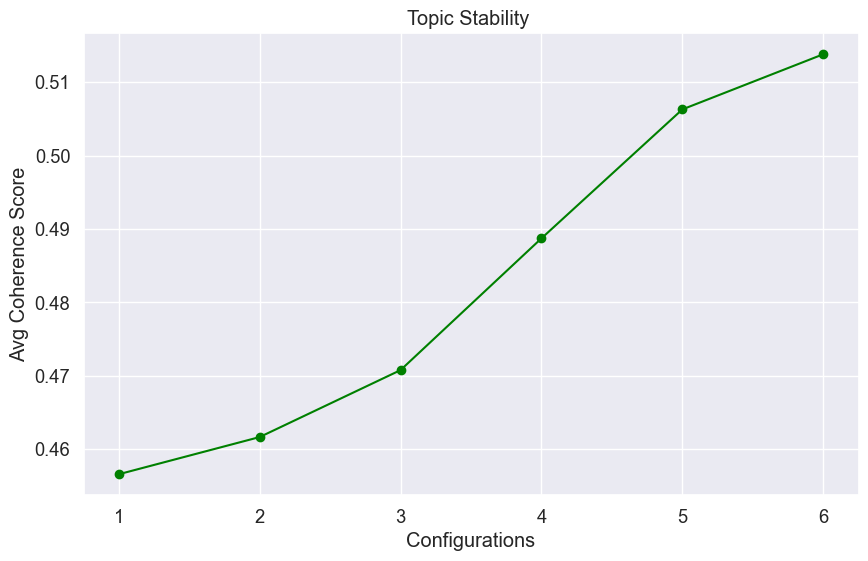

In [24]:
import matplotlib.pyplot as plt1

plt1.figure(figsize=(10, 6))
plt1.plot(settings,coherence, marker='o', label='Coherence Score', color='green')
plt1.xlabel('Configurations')
plt1.ylabel('Avg Coherence Score')
plt1.title('Topic Stability ')
plt1.grid(True)
plt1.show()

In [25]:
ch1

,Unnamed: 0,Reviews,sentence,processed,topic_words,sentence_topic_distributions,coherence_score
0,0,"Okay, so I'm not a big video game buff, but wa...","[""Okay, so I'm not a big video game buff, but ...",['Okay big video game buff game House Dead rea...,"[['game', 'video', 'shot', 'thing', 'case', 'D...","[{0: 0.99407756}, {2: 0.9829315}, {4: 0.952602...",0.405357
1,1,The premise of this movie has been tickling my...,['The premise of this movie has been tickling ...,['premise movie tickling imagination quite tim...,"[['film', 'Nothing', 'like', 'good', 'really',...","[{3: 0.9309553}, {1: 0.9007279}, {3: 0.9822631...",0.411718
2,2,Jim Carrey is back to much the same role that ...,['Jim Carrey is back to much the same role tha...,['Jim Carrey back much role played Mask timid ...,"[['movie', 'thing', 'love', 'life', 'nice', 's...","[{2: 0.9741891}, {3: 0.972633}, {0: 0.96392024...",0.393776
3,3,I read several mixed reviews and several of th...,['I read several mixed reviews and several of ...,['read several mixed review several downright ...,"[['tried', 'film', 'Scott', 'think', 'somethin...","[{4: 0.94707716}, {3: 0.96887493}, {0: 0.97990...",0.478592
4,4,Warning: Does contain spoilers.<br /><br />Ope...,['Warning: Does contain spoilers.<br /><br />O...,['Warning contain spoilersOpen EyesIf seen fil...,"[['begin', 'best', 'Sofia', 'shame', 'friend',...","[{3: 0.9607923}, {3: 0.8232325}, {4: 0.9570814...",0.463267
...,...,...,...,...,...,...,...
2495,2495,I thought the whole movie played out beautiful...,['I thought the whole movie played out beautif...,['thought whole movie played beautifully fresh...,"[['decent', 'ending', 'twist', 'idea', 'televi...","[{1: 0.9608026}, {1: 0.95261216}, {2: 0.872893...",0.656990
2496,2496,"""Seed"" is torture porn...no doubt about it. Bu...","['""Seed"" is torture porn...no doubt about it',...","['Seed torture porn doubt', 'strangely Uwe Bol...","[['go', 'without', 'around', 'even', 'decay', ...","[{1: 0.66315895, 3: 0.26237932}, {4: 0.9789787...",0.563503
2497,2497,The title alone (along with the poster) is eno...,['The title alone (along with the poster) is e...,['title alone along poster enough give away Pr...,"[['think', 'horror', 'IMDb', 'Still', 'would',...","[{3: 0.9639218}, {0: 0.970875}, {0: 0.9888235}...",0.390767
2498,2498,This is one of the best animated family films ...,['This is one of the best animated family film...,"['one best animated family film time', 'Moreov...","[['slightly', 'imagination', 'film', 'version'...","[{0: 0.930956}, {3: 0.9639247}, {2: 0.9789778}...",0.380943


In [26]:
ch2['topic_word'] = ch2['topic_words'].swifter.apply(ast.literal_eval)

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

In [27]:
x=ch2['topic_word'][0]

In [28]:
x

[['girl', 'shot', 'like', 'movie', 'lot', 'right', 'island', 'idea', 'since'],
 ['get',
  'well',
  'like',
  'enough',
  'kid',
  'sounded',
  'strongly',
  'think',
  'long'],
 ['little',
  'actor',
  'getting',
  'least',
  'old',
  'island',
  'every',
  'people',
  'find'],
 ['game', 'video', 'rave', 'people', 'dead', 'case', 'way', 'kid', 'shot'],
 ['Sure',
  'techno-slasher',
  'nugget',
  'imagine',
  'hand',
  'bullet',
  'machine',
  'everything',
  'stupid'],
 ['much',
  'shot',
  'thing',
  'music',
  'House',
  'nothing',
  'game',
  'better',
  'case']]

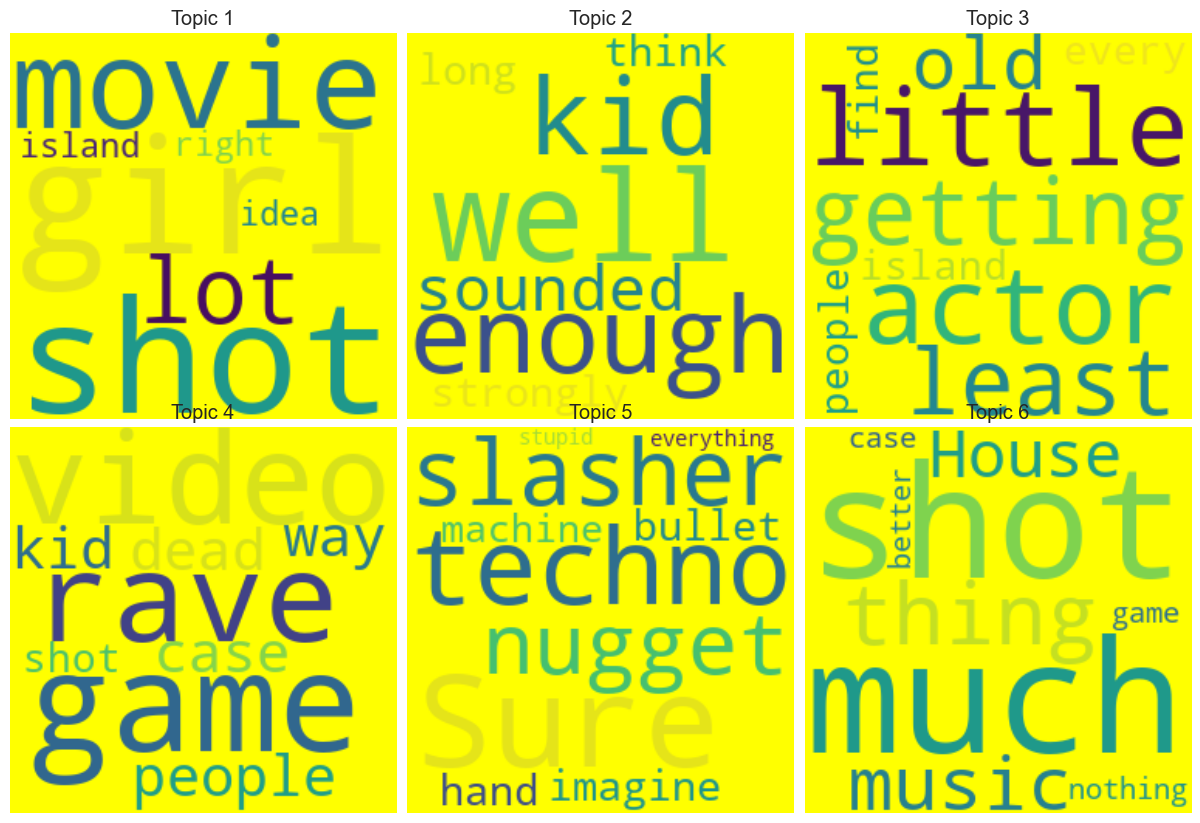

In [30]:
from wordcloud import WordCloud
def plot_word_cloud(words, index):
    wordcloud = WordCloud(width=250, height=250, background_color='yellow').generate(' '.join(words))
    plt.subplot(2, 3, index+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Topic {index+1}')
    plt.axis('off')

plt.figure(figsize=(12, 8))
for i, word_list in enumerate(x):
    plot_word_cloud(word_list, i)

plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.subplots_adjust(wspace=-0.02, hspace=0.02)
plt.show()

In [31]:
from collections import Counter
import matplotlib.pyplot as plt

def plot_top_k_words(processed_documents, k=10):
    all_words = [word for sublist in processed_documents for doc in sublist for word in doc]
    word_freq = Counter(all_words)
    top_words = word_freq.most_common(k)
    words, frequencies = zip(*top_words)
    colors = plt.cm.viridis(np.linspace(0, 1, k)) 
    plt.figure(figsize=(10, 6))
    bars = plt.bar(words, frequencies, color=colors)
    plt.xlabel('Words', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title(f'Top {k} Topic Words', fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

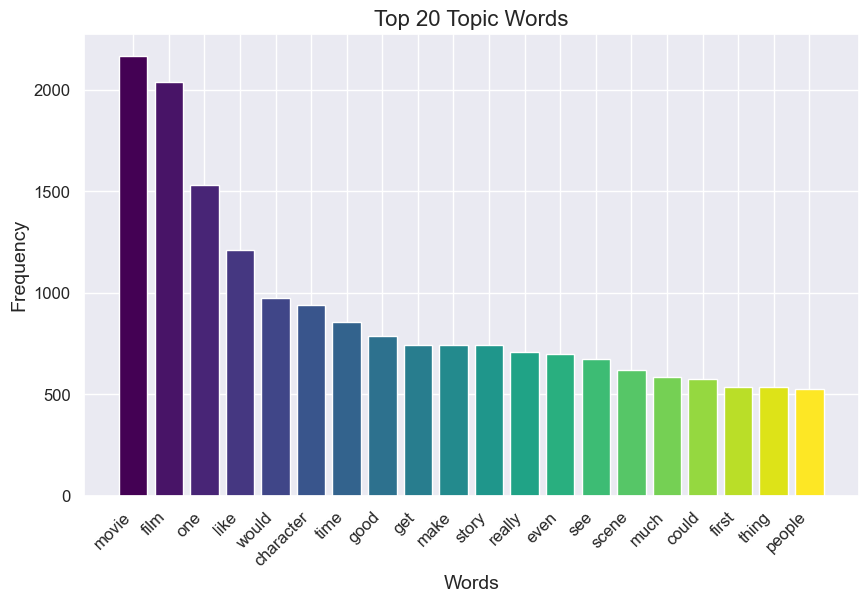

In [32]:
processed_documents = ch2['topic_word']
plot_top_k_words(processed_documents, k=20)

In [33]:
summary1.to_csv('1S.csv')
summary2.to_csv('2S.csv')
summary3.to_csv('3S.csv')
summary4.to_csv('4S.csv')
summary5.to_csv('5S.csv')
summary6.to_csv('6S.csv')

In [34]:
from collections import Counter

def k_words(processed_documents, k=10):
    all_words = [word for sublist in processed_documents for doc in sublist for word in doc.split()]
    word_freq = Counter(all_words)
    top_words = [word for word, _ in word_freq.most_common(k)]
    return top_words

In [35]:
def evaluate_relevance(summary, topic_keywords):
    relevance_score = 0
    for keyword in topic_keywords:
        if keyword.lower() in summary.lower():
            relevance_score += 1
    normalized_relevance_score = relevance_score / len(topic_keywords)
    return normalized_relevance_score

def evaluate_summary(df_summary):
    
    relevance_scores = []
    for summary, topic_keywords in zip(df_summary['Summary'], df_summary['top']):
        relevance_score = evaluate_relevance(summary, topic_keywords)
        relevance_scores.append(relevance_score)
    df_summary['Relevance Score'] = relevance_scores
    
    return df_summary

In [36]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\akvnr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\akvnr\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [37]:
def calculate_fluency_score(summary):
    tokens = word_tokenize(summary)
    tagged_tokens = pos_tag(tokens)
    correct_tags = ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS',
                    'NNP', 'NNPS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH',
                    'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']
    correct_count = sum(1 for _, tag in tagged_tokens if tag in correct_tags)
    fluency_score = correct_count / len(tokens)
    return fluency_score


In [38]:
ch1['topic_word'] = ch1['topic_words'].swifter.apply(ast.literal_eval)
summary1['top']=ch1['topic_word'].swifter.apply(k_words)
summary1=evaluate_summary(summary1)
summary1['Fluency Score'] = summary1['Summary'].apply(calculate_fluency_score)

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

In [39]:
summary1

,Summary,TBLabel,top,Relevance Score,Fluency Score
0,I can't stand it when well-known actors change...,postive,"[shot, Dead, House, kid, music, something, way...",0.8,0.940701
1,That alone is the main reason to why these two...,postive,"[film, really, still, Andrew, Nothing, like, m...",0.3,0.963504
2,"The results were not very promising, so it's n...",postive,"[movie, life, see, people, Carrey, man, TV, on...",0.7,0.951456
3,This plot was one of the more interesting ones...,postive,"[Scott, say, extremely, made, much, tried, fil...",0.5,0.956250
4,His name was Mr Warning: Does contain spoilers...,postive,"[something, film, one, David, year, begin, bes...",0.2,0.981481
...,...,...,...,...,...
2495,I thought the whole movie played out beautiful...,postive,"[idea, fresh, top, like, entirely, decent, end...",0.2,1.000000
2496,The films are somewhat surreal in this respect...,postive,"[without, go, would, movie, much, around, even...",1.0,0.916256
2497,"Maybe he can't carry the movie, but he gets pr...",postive,"[would, phone, movie, think, horror, IMDb, Sti...",0.6,0.882927
2498,None of these problems plague Castle in the Sk...,postive,"[film, animation, None, slightly, imagination,...",0.6,0.897849


In [40]:
ch2['topic_word'] = ch2['topic_words'].swifter.apply(ast.literal_eval)
summary2['top']=ch2['topic_word'].swifter.apply(k_words)
summary2=evaluate_summary(summary2)
summary2['Fluency Score'] = summary2['Summary'].apply(calculate_fluency_score)

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

In [41]:
ch3['topic_word'] = ch3['topic_words'].swifter.apply(ast.literal_eval)
summary3['top']=ch3['topic_word'].swifter.apply(k_words)
summary3=evaluate_summary(summary3)
summary3['Fluency Score'] = summary3['Summary'].apply(calculate_fluency_score)

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

In [42]:
ch4['topic_word'] = ch4['topic_words'].swifter.apply(ast.literal_eval)
summary4['top']=ch4['topic_word'].swifter.apply(k_words)
summary4=evaluate_summary(summary4)
summary4['Fluency Score'] = summary4['Summary'].apply(calculate_fluency_score)

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

In [43]:
ch5['topic_word'] = ch5['topic_words'].swifter.apply(ast.literal_eval)
summary5['top']=ch5['topic_word'].swifter.apply(k_words)
summary5=evaluate_summary(summary5)
summary5['Fluency Score'] = summary5['Summary'].apply(calculate_fluency_score)

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

In [44]:
ch6['topic_word'] = ch6['topic_words'].swifter.apply(ast.literal_eval)
summary6['top']=ch6['topic_word'].swifter.apply(k_words)
summary6=evaluate_summary(summary6)
summary6['Fluency Score'] = summary6['Summary'].apply(calculate_fluency_score)

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

In [45]:
relevance=[avg(summary1,'Relevance Score'),avg(summary2,'Relevance Score'),avg(summary3,'Relevance Score'),avg(summary4,'Relevance Score'),avg(summary5,'Relevance Score'),avg(summary6,'Relevance Score')]

In [46]:
fluency=[avg(summary1,'Fluency Score'),avg(summary2,'Fluency Score'),avg(summary3,'Fluency Score'),avg(summary4,'Fluency Score'),avg(summary5,'Fluency Score'),avg(summary6,'Fluency Score')]

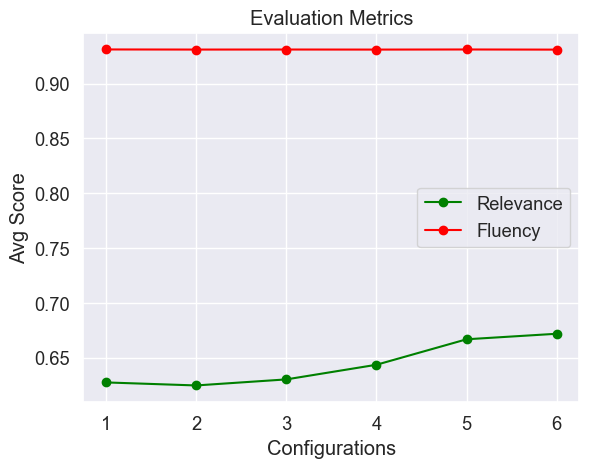

In [47]:

settings=[1,2,3,4,5,6]
plt.plot(settings, relevance, marker='o', label='Relevance', color='green')
plt.plot(settings, fluency, marker='o', label='Fluency', color='red')
plt.xlabel('Configurations')
plt.ylabel('Avg Score')
plt.title('Evaluation Metrics')
plt.legend()
plt.grid(True)
plt.show()


In [1]:
from rouge_score import rouge_scorer

def calculate_rouge(reference_summary, generated_summary):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference_summary, generated_summary)
    rouge1_score = [scores['rouge1'].precision, scores['rouge1'].recall, scores['rouge1'].fmeasure]
    rouge2_score = [scores['rouge2'].precision, scores['rouge2'].recall, scores['rouge2'].fmeasure]
    rougeL_score = [scores['rougeL'].precision, scores['rougeL'].recall, scores['rougeL'].fmeasure]
    
    return rouge1_score, rouge2_score, rougeL_score


In [58]:
PR = pd.read_csv('PageRank.csv')

In [66]:
PR=PR.iloc[:2500]

In [78]:
import numpy as np

avg_rouge_scores_list = []

for i in range(1, 7):
    print(i,end=' ')
    df_name = f"summary{i}"
    df = globals()[df_name]  
    
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    
    for index, row in df.iterrows():
        rouge1_score, rouge2_score, rougeL_score = calculate_rouge(PR.loc[index, 'Summary'], row['Summary'])
        
        rouge1_scores.append(rouge1_score)
        rouge2_scores.append(rouge2_score)
        rougeL_scores.append(rougeL_score)
    
    
    avg_rouge1_precision = np.mean([score[0] for score in rouge1_scores])
    avg_rouge1_recall = np.mean([score[1] for score in rouge1_scores])
    avg_rouge1_fmeasure = np.mean([score[2] for score in rouge1_scores])
    
    avg_rouge2_precision = np.mean([score[0] for score in rouge2_scores])
    avg_rouge2_recall = np.mean([score[1] for score in rouge2_scores])
    avg_rouge2_fmeasure = np.mean([score[2] for score in rouge2_scores])
    
    avg_rougeL_precision = np.mean([score[0] for score in rougeL_scores])
    avg_rougeL_recall = np.mean([score[1] for score in rougeL_scores])
    avg_rougeL_fmeasure = np.mean([score[2] for score in rougeL_scores])
    
    avg_rouge_scores_list.append({
        'df_name': df_name,
        'avg_rouge1_precision': avg_rouge1_precision,
        'avg_rouge1_recall': avg_rouge1_recall,
        'avg_rouge1_fmeasure': avg_rouge1_fmeasure,
        'avg_rouge2_precision': avg_rouge2_precision,
        'avg_rouge2_recall': avg_rouge2_recall,
        'avg_rouge2_fmeasure': avg_rouge2_fmeasure,
        'avg_rougeL_precision': avg_rougeL_precision,
        'avg_rougeL_recall': avg_rougeL_recall,
        'avg_rougeL_fmeasure': avg_rougeL_fmeasure
    })

for avg_rouge_scores in avg_rouge_scores_list:
    print("Average ROUGE-1 Precision, Recall, F-measure:", [avg_rouge_scores['avg_rouge1_precision'],
                                                            avg_rouge_scores['avg_rouge1_recall'],
                                                            avg_rouge_scores['avg_rouge1_fmeasure']])
    print("Average ROUGE-2 Precision, Recall, F-measure:", [avg_rouge_scores['avg_rouge2_precision'],
                                                            avg_rouge_scores['avg_rouge2_recall'],
                                                            avg_rouge_scores['avg_rouge2_fmeasure']])
    print("Average ROUGE-L Precision, Recall, F-measure:", [avg_rouge_scores['avg_rougeL_precision'],
                                                            avg_rouge_scores['avg_rougeL_recall'],
                                                            avg_rouge_scores['avg_rougeL_fmeasure']])
    print()


1 2 3 4 5 6 Average ROUGE-1 Precision, Recall, F-measure: [0.4871821783361377, 0.5152470043006505, 0.4826343686979055]
Average ROUGE-2 Precision, Recall, F-measure: [0.30473420341532564, 0.33749208465061104, 0.3093497064091066]
Average ROUGE-L Precision, Recall, F-measure: [0.3269352386560825, 0.3485131850515318, 0.3248735846918381]

Average ROUGE-1 Precision, Recall, F-measure: [0.47388033814646835, 0.5771981981530354, 0.5032141863739231]
Average ROUGE-2 Precision, Recall, F-measure: [0.309428431707842, 0.38981018181214155, 0.3340073991038651]
Average ROUGE-L Precision, Recall, F-measure: [0.32345282228886735, 0.3966586691008099, 0.34416368655209706]

Average ROUGE-1 Precision, Recall, F-measure: [0.46119892769809395, 0.6215653691692854, 0.5123720013314049]
Average ROUGE-2 Precision, Recall, F-measure: [0.3090767923191173, 0.42672687686266, 0.34723115649813396]
Average ROUGE-L Precision, Recall, F-measure: [0.3201931785698249, 0.43391968065323727, 0.356301175709895]

Average ROUGE-1 P

In [ ]:

avg_rouge1_precision_list = []
avg_rouge1_recall_list = []
avg_rouge1_fmeasure_list = []
avg_rouge2_precision_list = []
avg_rouge2_recall_list = []
avg_rouge2_fmeasure_list = []
avg_rougeL_precision_list = []
avg_rougeL_recall_list = []
avg_rougeL_fmeasure_list = []

for avg_rouge_scores in avg_rouge_scores_list:
    avg_rouge1_precision_list.append(avg_rouge_scores['avg_rouge1_precision'])
    avg_rouge1_recall_list.append(avg_rouge_scores['avg_rouge1_recall'])
    avg_rouge1_fmeasure_list.append(avg_rouge_scores['avg_rouge1_fmeasure'])
    avg_rouge2_precision_list.append(avg_rouge_scores['avg_rouge2_precision'])
    avg_rouge2_recall_list.append(avg_rouge_scores['avg_rouge2_recall'])
    avg_rouge2_fmeasure_list.append(avg_rouge_scores['avg_rouge2_fmeasure'])
    avg_rougeL_precision_list.append(avg_rouge_scores['avg_rougeL_precision'])
    avg_rougeL_recall_list.append(avg_rouge_scores['avg_rougeL_recall'])
    avg_rougeL_fmeasure_list.append(avg_rouge_scores['avg_rougeL_fmeasure'])


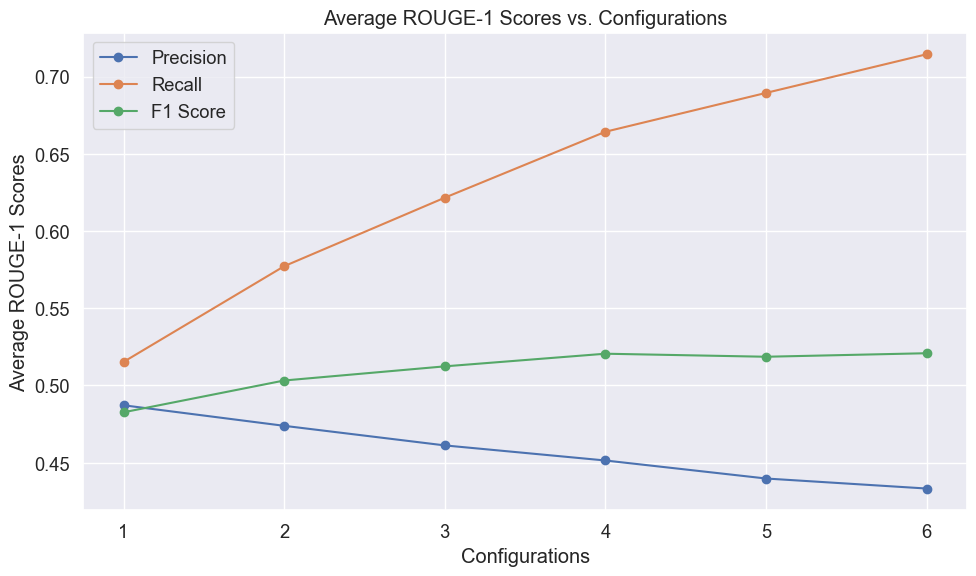

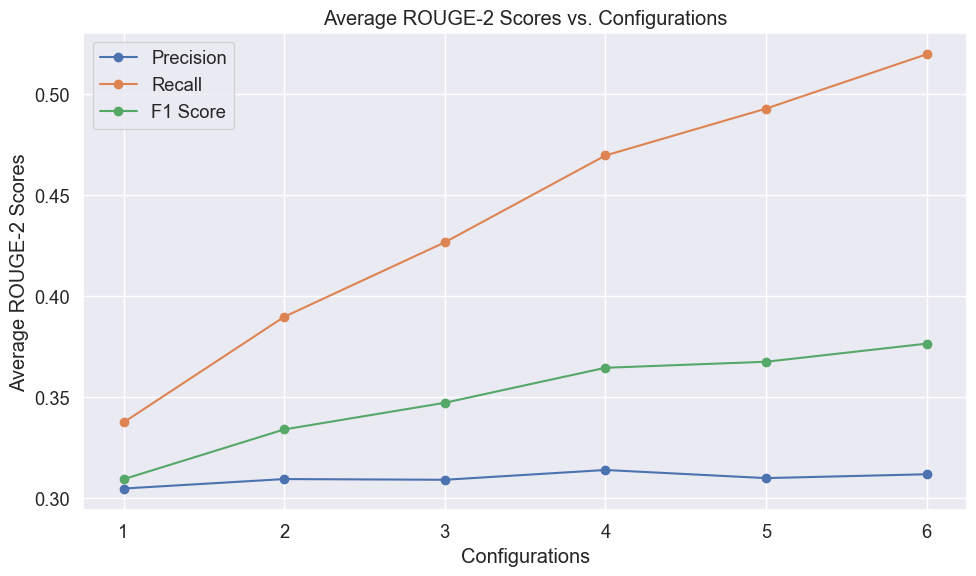

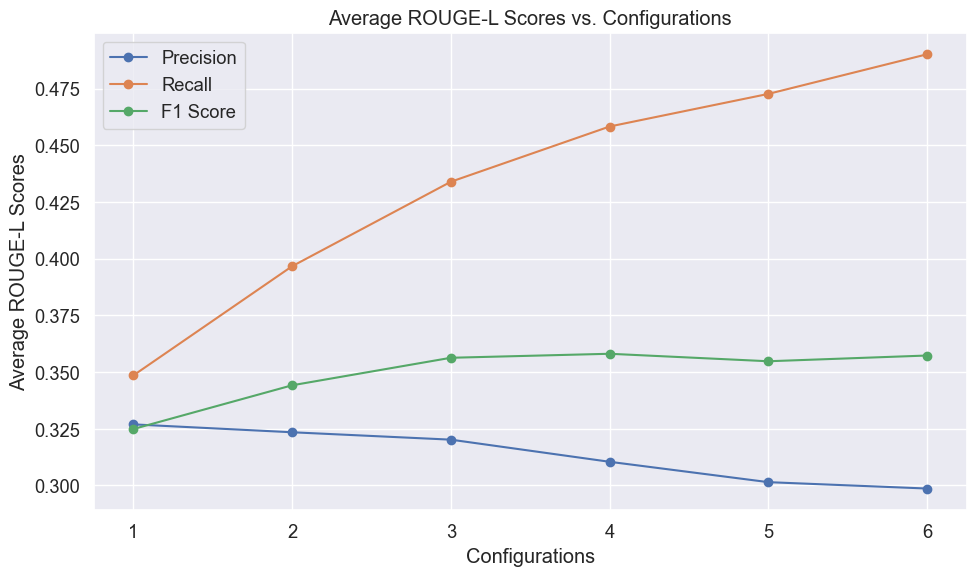

In [84]:
import matplotlib.pyplot as plt

configurations = [1,2,3,4,5,6]
def plot_rouge_metric(metric_list, metric_name):
    plt.figure(figsize=(10, 6))
    for metric_values in metric_list:
        plt.plot(configurations, metric_values, marker='o')
    plt.title(f'Average {metric_name} Scores vs. Configurations')
    plt.xlabel('Configurations')
    plt.ylabel(f'Average {metric_name} Scores')
    plt.legend(['Precision', 'Recall', 'F1 Score'])
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_rouge_metric([avg_rouge1_precision_list, avg_rouge1_recall_list, avg_rouge1_fmeasure_list], "ROUGE-1")

plot_rouge_metric([avg_rouge2_precision_list, avg_rouge2_recall_list, avg_rouge2_fmeasure_list], "ROUGE-2")

plot_rouge_metric([avg_rougeL_precision_list, avg_rougeL_recall_list, avg_rougeL_fmeasure_list], "ROUGE-L")
